# Introduction

From the file phase1_import_tweets.py I imported 34339 tweets that contains any of these words Russia, Ukraine, or #UkraineRussiaWar.

#### Import necessary libraries 

In [798]:
import pandas as pd
import numpy  as np
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
import os

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 # 1. Raw Data

#### Read raw Data to a Dataframe
After importing the tweets using the Twitter API in the import_tweets_hashtag.py file, we will read it using a dataframe, and check the shape and the missing data on the raw data

In [2]:
raw_df = pd.read_csv('./data/raw_data.csv')
#raw_df.sample(10)
raw_df.shape

(16000, 17)

<AxesSubplot:>

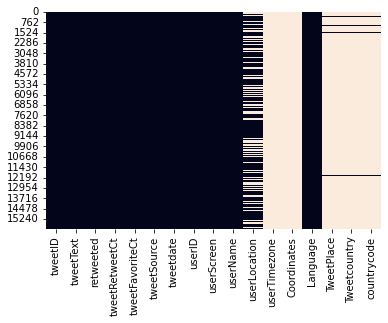

In [3]:
sns.heatmap(raw_df.isnull(), cbar=False)

# 2. Cleaning Process

#### Data Dictionary 

| Syntax                | Description |
| -----------           | ----------- |
|- tweetID :            | The unique identifier for Tweet. The dataset contain 34339 uniq tweets | 
|- tweetText :          | The actual text of the tweet |
|- tweetRetweetCt :     | Number of times this Tweet has been retweeted|
|- tweetFavoriteCt:     | Indicates approximately how many times this Tweet has been liked by Twitter users |
|- tweetCreated:        | UTC time when this Tweet was created  |
|- userID:              | The user ID who posted this Tweet |
|- userName:            | The user Name who posted this Tweet |
|- userLocation:        | The location of the user  |
|- Tweetcountry:        | The location of the user  |

In [4]:
tweet_df = raw_df[['tweetID','tweetText','retweeted', 'tweetRetweetCt','tweetFavoriteCt','tweetdate','userID','userName','userLocation','TweetPlace','Tweetcountry','countrycode']]
tweet_df.shape

(16000, 12)

#### Change the tweetdate to datetime format  

In [6]:
#tweet_df['tweetdate'] = pd.to_datetime(tweet_df['tweetdate'])
#tweet_df['date'] = tweet_df['tweetdate'].dt.date
tweet_df.date.value_counts()

2022-02-28    16000
Name: date, dtype: int64

#### Find and delete the duplicate tweets

In [7]:
tweet_df.tweetText.value_counts()

@Steam @Steam\n\n BLOCK Russia #StopWarInUkraine #StopRussia                                                                                      6
@nytimes Still very far from making a scratch on Putin. He continues to bomb Ukraine.\n#Embargo on Russian Oil and Gas                            5
@NATO close the sky over #Ukraine!\n#StopRussianAggression #StopWarInUkraine #StopRussia #StopPutin                                               4
@BostonDynamics @SamuelAdamsBeer STOP RUSSIAN AGGRESSION AGAINST #UKRAINE. Ukraine need your help 🙏\n#StandWithUkriane #StopRussianAgression      3
@Ukraine Every Entertainment Platform should be banned for russia                                                                                 3
                                                                                                                                                 ..
@nypost And this is how you know that billionaire investor Bill Ackman is laundering money through Ukraine.     

In [8]:
tweet_df['duplicattweet'] = tweet_df.duplicated(subset=['tweetText'], keep='first')

/tmp/ipykernel_23351/3049151882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['duplicattweet'] = tweet_df.duplicated(subset=['tweetText'], keep='first')


In [9]:
tweet_df.duplicattweet.value_counts()

False    15964
True        36
Name: duplicattweet, dtype: int64

In [10]:
tweet_df.drop(tweet_df[tweet_df.duplicattweet == True].index, inplace=True)
tweet_df.duplicattweet.value_counts()

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


False    15964
Name: duplicattweet, dtype: int64

#### Fill the missing of user location with tweet country

The process of obtaining country code is depend on the userlocation colume. it goes through long process 
I used the country_code.csv to create a dictionary 

In [ ]:
tweet_df = pd.read_csv('./data/cleaned_data.csv')

Set xx value (Not Defined) in countrycode to all rows that have missing vlaue in both countrycode & userLocation

In [11]:
import csv
with open('./data/country_code.csv', mode='r') as inp:
    reader = csv.reader(inp)
    code_dic = {rows[0]:rows[1] for rows in reader}

code_dic['Not Defined'] = 'XX'
#print(code_dic)

In [76]:
tweet_df[tweet_df['countrycode'].isnull() & tweet_df['userLocation'].isnull()]['userLocation']

Series([], Name: userLocation, dtype: object)

Set all null value in both countrycode and userLocation to Not Defined 

In [45]:
tweet_df['countrycode'] = np.where(tweet_df['countrycode'].isnull() & tweet_df['userLocation'].isnull(), code_dic.get('Not Defined'), tweet_df['countrycode'])

/tmp/ipykernel_23351/3630576414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['countrycode'] = np.where(tweet_df['countrycode'].isnull() & tweet_df['userLocation'].isnull(), code_dic.get('Not Defined'), tweet_df['countrycode'])


In [ ]:
tweet_df['userLocation'].nunique

Check all null value in countrycode but has a value in userLocation

In [778]:
country_dic = { 'Not Defined'   : 'Mountains|WORLD|worlds|elsewhere|文科省と厚労省の狭間|stupid|worldwide|said|Men|Matter|Heart|.com|Asia Pacific|Street|@|Stolen|Ponamogoatitjg|Frozen tundra North|/|Trumpsylvania|by way|Hotel|your|upset|San Sebastian|Unknown|Galaxy|Internet|Vaccinated|Metro|Meta|internet|Some Where|INCOME|gritty|Earth|Between|SAG/AFTRA|美丽的大麻猫岛|Wschód|MV1|iPhone|BIO|Imo|Here|since|Дитина Світу|Chinadastan|NEWSLETTER|Text|They|DMV|World|Query hell|22|🕳️🐇|Free|free|Happy Valley|Alba gu bràth|The World|Somewhere|christmas town|𝔦𝔫𝔣𝔢𝔯𝔫𝔞𝔩|Astronesia|Schuylkill Haven|Bedroom|Autumn|21|Mom|Nebula|Lissachan|Django|coming soon|Wherever|exile|Home|Any pronouns|Metaverse|http://|area 51|La Isla Bonita|Not|home',
                'United States' : 'United States|American|US|Miami|USA|LA|Atlanta|Philadelphia|Poughkeepsie|Albany, GA|carolina|Carol Stream, IL|Cape Coral, FL|brooklyn|L.A|Klamath Falls, OR|Westchester County, NY|Deadwood, SD|Baltimore|washington, dc|Brooklyn|Fort Wayne, IN|Seattle|Deep South|East Louisville KY|Myrtle Beach, SC|Highlands Ranch, CO|Sayre, PA|Portland, OR|U.S.A|nyc|Austin, TX|Austin, Tx|Newton, NJ|Nashville, TN|Kailua, HI|Manhattan, NY|HARLEM, NY|Eugene, OR|Dallas, TX|HARLEM, NY|Mansfield, MA|Central IL|Littleton, CO|Miami, FL|new york city|Fort Worth|Gig Harbor, WA|Chicago|Syracuse, NY|Sacramento, Ca|Atlanta, GA|Lansing, MI|Newark, NJ|Palermo, NJ|Philadelphia, PA|kansas|Charlotte, NC|Birmingham, AL|Alabama|AlaskaArizona|Arkansas|California|Colorado|Connecticut|Delaware|Florida|Georgia|Hawaii|Idaho|Illinois|Indiana|Iowa|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New Hampshire|New Jersey|New Mexico|New York|North Carolina|North Dakota|Ohio|Oklahoma|Oregon|Pennsylvania|Rhode Island|South Carolina|South Dakota|Tennessee|Texas|Utah|Vermont|Virginia|Washington|West Virginia|Wisconsin|Wyoming|Holtsville, NY|Adjuntas, PR|Aguada, PR|Aguadilla, PR|Maricao, PR|Anasco, PR|Angeles, PR|Arecibo, PR|Bajadero, PR|Barceloneta, PR|Boqueron, PR|Cabo Rojo, PR|Penuelas, PR|Camuy, PR|Castaner, PR|Rosario, PR|Sabana Grande, PR|	Ciales, PR|	Utuado, PR|	Dorado, PR|Ensenada, PR|Florida, PR|Garrochales, PR|Guanica, PR|Guayanilla, PR|Hatillo, PR|Hormigueros, PR|Isabela, PR|Jayuya, PR|Lajas, PR|Lares, PR|Las Marias, PR|Manati, PR|	Moca, PR|Rincon, PR|Quebradillas, PR|Mayaguez, PR|San German, PR|San Sebastian, PR|	Morovis, PR|Sabana Hoyos, PR|San Antonio, PR|Vega Alta, PR|Vega Baja, PR|Yauco, PR|Aguas Buenas, PR|Aguirre, PR|Aibonito, PR|Maunabo, PR|Arroyo, PR|	Mercedita, PR|Ponce, PR|Naguabo, PR|Naranjito, PR|Orocovis, PR|Palmer, PR|Patillas, PR|Caguas, PR|Canovanas, PR|Ceiba, PR|Cayey, PR|Fajardo, PR|Cidra, PR|Puerto Real, PR|Punta Santiago, PR|Roosevelt Roads, PR|Rio Blanco, PR|Rio Grande, PR|Salinas, PR|San Lorenzo, PR|Santa Isabel, PR|Vieques, PR|Villalba, PR|Yabucoa, PR|Coamo, PR|Las Piedras|Loiza, PR|Luquillo, PR|Culebra, PR|Juncos, PR|Gurabo, PR|Coto Laurel, PR|Comerio, PR|Corozal, PR|Guayama, PR|La Plata, PR|Humacao, PR|Barranquitas, PR|Juana Diaz, PR|St Thomas, VI|Christiansted, VI|St John, VI|Frederiksted, VI|Kingshill, VI|San Juan, PR|Fort Buchanan, PR|GPO, PR|Toa Baja, PR|Sabana Seca, PR|Toa Alta, PR|Bayamon, PR|Catano, PR|Guaynabo, PR|Trujillo Alto, PR|Saint Just, PR|Carolina, PR|Agawam, MA|Amherst, MA|Barre, MA|Belchertown, MA|Blandford, MA|Bondsville, MA|Brimfield, MA|Chester, MA|Chesterfield, MA|Chicopee, MA|Cummington, MA|	Easthampton, MA|East Longmeadow, MA|East Otis, MA|Feeding Hills, MA|Gilbertville, MA|Goshen, MA|Granby, MA|Granville, MA|Hadley, MA|Hampden, MA|Hardwick, MA|Hatfield, MA|Haydenville, MA|Holyoke, MA|Huntington, MA|Leeds, MA|Leverett, MA|Ludlow, MA|Monson, MA|North Amherst, MA|Northampton, MA|Florence, MA|North Hatfield, MA|Oakham, MA|Palmer, MA|Plainfield, MA|Russell, MA|Shutesbury, MA|Southampton, MA|South Barre, MA|Hadley, MA|Southwick, MA|Thorndike, MA|Three Rivers, MA|Wales, MA|Ware, MA|Warren, MA|West Chesterfield, MA|Westfield, MA|West Hatfield, MA|West Springfield, MA|	West Warren, MA|Whately, MA|Wheelwright, MA|Wilbraham, MA|Williamsburg, MA|Woronoco, MA|Worthington, MA|Springfield, MA|Longmeadow, MA|Indian Orchard, MA|Pittsfield, MA|Adams, MA|Ashley Falls, MA|Becket, MA|Berkshire, MA|Cheshire, MA|Dalton, MA|Glendale, MA|Great Barrington, MA|Hinsdale, MA|Housatonic, MA|Lanesboro, MA|Lee, MA|Lenox, MA|Lenox Dale, MA|Middlefield, MA|Mill River, MA|Monterey, MA|North Adams, MA|North Egremont, MA|Otis, MA|Richmond, MA|Sandisfield, MA|Savoy, MA|Sheffield, MA|South Egremont, MA|Southfield, MA|South Lee, MA|Stockbridge, MA|Tyringham, MA|West Stockbridge, MA|Williamstown, MA|Windsor, MA|Greenfield, MA|	Ashfield, MA|Athol, MA|Bernardston, MA|Buckland, MA|Charlemont, MA|Colrain, MA|Conway, MA|Deerfield, MA|Drury, MA|Erving, MA|Heath, MA|Lake Pleasant, MA|Millers Falls, MA|Monroe Bridge, MA|Montague, MA|Gill, MA|New Salem, MA|Northfield, MA|Orange, MA|Petersham, MA|Rowe, MA|Royalston, MA|Shelburne Falls, MA|South Deerfield, MA|Sunderland, MA|Turners Falls, MA|Warwick, MA|Wendell, MA|Wendell Depot, MA|Fitchburg, MA|Ashburnham, MA|Ashby, MA|Ayer, MA|Devens, MA|Baldwinville, MA|East Templeton, MA|Gardner, MA|Westminster, MA|Groton, MA|Harvard, MA|Hubbardston, MA|Leominster, MA|Littleton, MA|Lunenburg, MA|Pepperell, MA|Shirley, MA|Still River, MA|Templeton, MA|Townsend, MA|West Groton, MA|West Townsend, MA|Winchendon, MA|Winchendon Springs, MA|Auburn, MA|Berlin, MA|Blackstone, MA|Boylston, MA|Brookfield, MA|Charlton, MA|Charlton City, MA|Charlton Depot, MA|Clinton, MA|East Brookfield, MA|	Douglas, MA|East Princeton, MA|Fiskdale, MA|Grafton, MA|Holden, MA|Holland, MA|Jefferson, MA|Lancaster, MA|Leicester, MA|Linwood, MA|Manchaug, MA|Millbury, MA|Millville, MA|New Braintree, MA|Northborough,MA|Northbridge, MA|North Brookfield|, MA|, AL|, AK|, AZ|, AR|, CA|, CO|, CT|, DE|, FL|, GA|, HI|, ID|, IL|, IN|, IA|, KS|, KY|, LA|, ME|, MD|, MA|, MI|, MN|, MS|, MO|, MT|, NE|, NV|, NH|, NJ|, NM|, NY|, NC|, ND|, OH|, OK|, OR|, PA|, RI|, SC|, SD|, TN|, TX|, UT|, VT|, VA|, WA|, WV|, WI|, WY|, al|, ak|, az|, ar|, ca|, co|, ct|, de|, fl|, ga|, hi|, id|, il|, in|, ia|, ks|, ky|, la|, me|, md|, ma|, mi|, mn|, ms|, mo|, mt|, ne|, nv|, nh|, nj|, nm|, ny|, nc|, nd|, oh|, ok|, or|, pa|, ri|, sc|, sd|, tn|, tx|, ut|, vt|, va|, wa|, wv|, wi|, wy',
                'Canada'   : 'Canada|CA|Ontario|Mississauga|Montréal, Québec|Halifax|Tkoronto|Toronto|Cape Breton|Edmonton|Alberta|Victoria|Tkoronto|Nunavut|Quebec|Northwest Territories|Ontario|British Columbia|Alberta|Saskatchewan|Manitoba|Yukon|Newfoundland and Labrador|New Brunswick|Nova Scotia|Prince Edward Island|Ottawa',
                'United Kingdom' : 'United Kingdom|England|Lincolnshire|Midwest|Great Basin Kingdom|South East, England|Manchester, England|Manchester|British Isles|London|UK|Great Britain|Nottingham|U K|Scotland|Livingston|Aberconwy and Colwyn|Aberdeen City|Aberdeenshire|Anglesey|Angus|Antrim|Argyll and Bute|Armagh|Avon|Ayrshire|Bath and NE Somerset|Bedfordshire|Belfast|Berkshire|Berwickshire|BFPO|Blaenau Gwent|Buckinghamshire|Caernarfonshire|Caerphilly|Caithness|Cambridgeshire|Cardiff|Cardiganshire|Carmarthenshire|Ceredigion|Channel Islands|Cheshire|City of Bristol|Clackmannanshire|Clwyd|Conwy|Cornwall/Scilly|Cumbria|Denbighshire|Derbyshire|Derry/Londonderry|Devon|Dorset|Down|Dumfries and Galloway|Dunbartonshire|Dundee|Durham|Dyfed|East Ayrshire|East Dunbartonshire|East Lothian|East Renfrewshire|East Riding Yorkshire|East Sussex|Edinburgh|England|Essex|Falkirk|Fermanagh|Fife|Flintshire|Glasgow|Gloucestershire|Greater London|Greater Manchester|Gwent|Gwynedd|Hampshire|Hartlepool|Hereford and Worcester|Hertfordshire|Highlands|Inverclyde|Inverness-Shire|Isle of Man|Isle of Wight|Kent|Kincardinshire|Kingston Upon Hull|Kinross-Shire|Kirklees|Lanarkshire|Lancashire|Leicestershire|Lincolnshire|Londonderry|Merseide|Merthyr Tydfil|Mid Glamorgan|Mid Lothian|Middlesex|Monmouthshire|Moray|Neath & Port Talbot|Newport|Norfolk|North Ayrshire|North East Lincolnshire|North Lanarkshire|North Lincolnshire|North Somerset|North Yorkshire|Northamptonshire|Northern Ireland|Northumberland|Nottinghamshire|Orkney and Shetland Isles|Oxfordshire|Pembrokeshire|Perth and Kinross|Powys|Redcar and Cleveland|Renfrewshire|Rhonda Cynon Taff|Rutland|Scottish Borders|Shetland|Shropshire|Somerset|South Ayrshire|South Glamorgan|South Gloucesteshire|South Lanarkshire|South Yorkshire|Staffordshire|Stirling|Stockton On Tees|Suffolk|Surrey|Swansea|Torfaen|Tyne and Wear|Tyrone|Vale Of Glamorgan|Wales|Warwickshire|West Berkshire|West Dunbartonshire|West Glamorgan|West Lothian|West Midlands|West Sussex|West Yorkshire|Western Isles|Wiltshire|Wirral|Worcestershire|Wrexham|York',
                'Indonesia'  : 'Indonesia|Jakarta|Surabaya',
                'Ukraine' : 'Ukraine|Украина|Кривий Ріг|Kryvyi Rih|Україна|Krivoy Rog|Snake Island|Kiev|Kyiv|Київ|Харків|Kharkiv|Odesa|Одеса|Dnipro|Дніпро|Donetsk|Донецьк|Cherkasy|Chernihiv|Chernivtsi|Dnipropetrovsk|Donetsk|Ivano-Frankivsk|Kharkiv|Kherson|Khmelnytskyi|Kiev|Kirovohrad|Luhansk|Lviv|Mykolaiv|Odessa|Poltava|Rivne|Sumy|Ternopil|Vinnytsia|Volyn|Zakarpattia|Zaporizhia|Zhytomyr',
                'Poland' : 'Poland|Kraków|Warszawa|wielkopolskie|Greater Poland|kujawsko-pomorskie|małopolskie|łódzkie|Kuyavia-Pomerania|Lesser Poland|Łódź',
                'India' : 'India|New Delhi|Hyderabad|Mumbai|Punjab|Pune',
                'Germany' : 'Germany|Berlin|Bayern|Bavaria|Niedersachsen|Lower Saxony|Baden-Württemberg|Rheinland-Pfalz|Rhineland-Palatinate|Sachsen|Saxony|Thüringen|Thuringia|Hessen|Nordrhein-Westfalen|North Rhine-Westphalia|Sachsen-Anhalt|Saxony-Anhalt|Brandenburg|Mecklenburg-Vorpommern|Hamburg|Schleswig-Holstein|Saarland|Bremen|Munich, Bavaria|Munich|Düsseldorf',
                'Saudi Arabia' : 'المملكة العربية السعودية|Kingdom of Saudi Arabia|Saudi Arabia|KSA|Jeddah|Makkah|Riyadh',
                'Slovenia' : 'Slovenia|Ljubljana|Slovenija|Osrednjeslovenska|Littoral–Inner|Mura|Pomurska|Drava|Podravska|Koroška|Carinthia',
                'Switzerland' : 'Switzerland|Zurich|Basel|Geneva|Swiss|Zürich|Bern|Berne|Luzern|Uri|Schwyz|Unterwalden|Nidwalden|Glarus|Zug',
                'Yemen':'اليمن|Yaman|Yemen',
                'Turkey': 'Turkey|Ankara|Istanbul|İzmir|Antalya',
                'Uganda': 'Uganda|Kampala|Nansana|Kira|Mbarara',
                'Portugal' : 'Portugal|Porto|Amadora|Lisbon|Braga',
                'Australia' : 'Australia|Sydney|Katoomba|Melbourne|vienna|australia|Canberra',
                'Ireland' : 'Ireland|Dublin|Cork|Limerick|Galway|Waterford|Dunshaughlin',
                'Nigeria' : 'Nigeria|Lagos|Kano|Oyo|Edo|Abuja',
                'New Zealand' : 'New Zealand|Central Hawke|Auckland|Christchurch|Wellington|Hamilton|Tauranga',
                'Finland' : 'Finland|Jyväskylä|Helsinki|Oulu',
                'Argentina': 'Argentina|Buenos Aires|Cordoba|Rosario|Mendoza|La Plata|Tucumán',
                'Czech Republic' : 'Czech Republic|Brno|Ostrava|Prague',
                'Netherlands' : 'Netherlands|Amsterdam|Drenthe|Flevoland|Friesland|Gelderland|Groningen|Limburg|North Brabant|North Holland|Overijssel|Zeeland|Utrecht|South Holland|Gouda|Turfmarkt|Hague|',
                'Morocco' : 'Morocco|Casablanca|Fez|Tangier|Marrakesh|Tanger',
                'France' : 'France|Le Mans|Paris|Marseille|Lyon|Toulouse|Crozet',
                'Brazil' : 'Brazil|isla miel|São Paulo|Brasília|Brasil',
                'Nigeria' : 'Nigeria|Yobe|Maiduguri|Yobe, Maiduguri',
                'Russian Federation' : 'Russia|Moscow|Saint Petersburg|Novosibirsk|Austin|Saint Petersburg|Khanty-Mansiysk|belgorod,russia',
                'China' : 'China|Beijing|Hong Kong',
                'Ethiopia' : 'Ethiopia|ቤቴ|Addis Ababa|Mekelle|Gondar|Adama',
                'Belgium' :'Belgium|België|Brussels',
                'Malaysia' : 'Malaysia|Kuala Lumpur',
                'Slovakia' : 'Slovakia',
                'Italy' : 'Italy|Italia|Como|Calabria|Pavia|Venice|Rome|Romania',
                'Azerbaijan' : 'Azerbaijan|Shushi',
                'Spain' : 'Spain|Tenerife|Mallorca|Gran Canaria|Lanzarote|Ibiza|Fuerteventura|Menorca|La Palma|La Gomera|Formentera|El Hierro',
                'Jamaica' : 'Jamaica',
                'Bangladesh' :'Bangladesh|bangladesh|Dhaka|BANGLADESH',
                'Czech Republic' : 'Czechia|Czech Republic|Czech',
                'Egypt' : 'Egypt|cairo|Cairo|Alexandria'
                }


In [776]:
print(tweet_df[tweet_df['countrycode'].isnull() & tweet_df['userLocation'].notnull()]['userLocation'])

310                                   
464      Bezuidenhout-Midden, Den Haag
511                             Norway
532           Saint-Hélène, petite ile
538                       South Africa
                     ...              
15706                       Blockchain
15707          4th turning: 2008-2030s
15717                    The Mountains
15726                           WFH...
15740                              🇺🇦 
Name: userLocation, Length: 2797, dtype: object


In [771]:
tweet_df.userLocation.value_counts()

United States               219
London, England             119
USA                         108
London                      102
Canada                       91
                           ... 
Fairyland                     1
The Underground Railroad      1
Martock, England              1
winnipeg                      1
Not the US                    1
Name: userLocation, Length: 4690, dtype: int64

In [779]:
Key_word = 'Not Defined'
country_key = Key_word
country_Name = country_dic[Key_word]
print(code_dic.get(country_key))

XX


In [780]:
tweet_df[tweet_df['userLocation'].str.contains(country_Name,na=False) & tweet_df['countrycode'].isnull()]['userLocation']

3093                  Manarai Mountains
3859                    Rocky Mountains
7645                    Rocky Mountains
10847                    Blue Mountains
13165    Mountains, Forests, Waterfalls
15717                     The Mountains
Name: userLocation, dtype: object

In [781]:
tweet_df['countrycode'] = np.where(tweet_df['userLocation'].str.contains(country_Name,na=False) & tweet_df['countrycode'].isnull(), code_dic.get(country_key), tweet_df['countrycode'])

/tmp/ipykernel_23351/874373601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['countrycode'] = np.where(tweet_df['userLocation'].str.contains(country_Name,na=False) & tweet_df['countrycode'].isnull(), code_dic.get(country_key), tweet_df['countrycode'])


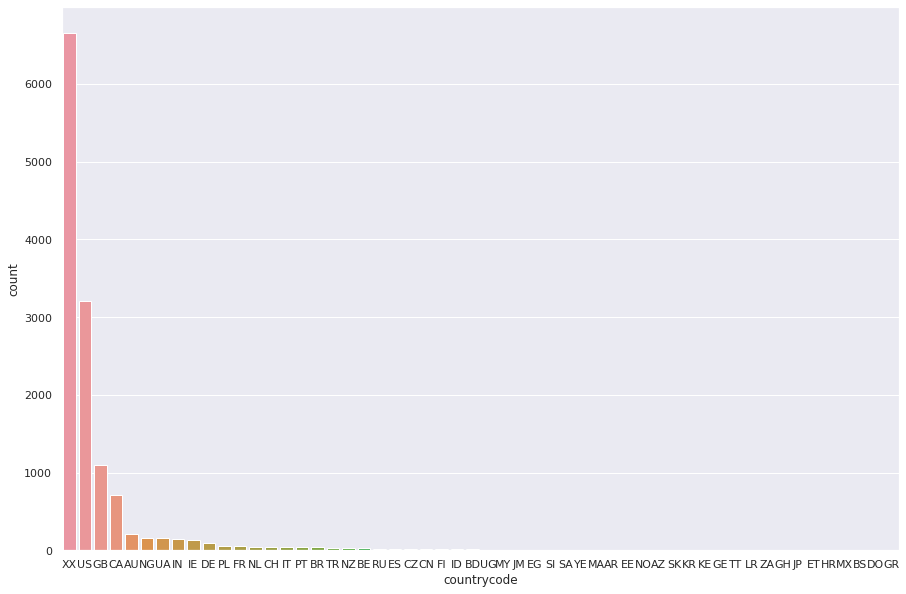

In [993]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,10))
ax = sns.countplot(x="countrycode", data=tweet_df, order = tweet_df['countrycode'].value_counts().index)

In [708]:
tweet_df.countrycode.isnull().sum()

2860

In [654]:
tweet_df.countrycode.value_counts()

XX    6628
US    3179
GB    1092
CA     705
AU     206
NG     157
UA     154
IN     146
IE     133
DE      96
PL      57
FR      50
NL      47
CH      43
IT      43
PT      41
BR      39
TR      33
NZ      27
BE      26
RU      22
CN      18
CZ      17
FI      16
ID      13
UG       8
SI       6
MY       6
SA       4
MA       4
AR       4
KR       3
NO       3
EE       3
AZ       3
SK       3
ES       2
YE       1
ZA       1
KE       1
GE       1
JM       1
TT       1
LR       1
JP       1
ET       1
BS       1
MX       1
HR       1
DO       1
GH       1
GR       1
Name: countrycode, dtype: int64

#### Text Processing

In [1006]:
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.util import bigrams, trigrams, ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, wordnet
import re
from wordcloud import WordCloud, STOPWORDS

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [994]:
tweet_df = pd.read_csv('./data/cleaned_data.csv')

In [995]:
tweet_df['tweetText'].head()

0    @RealPepeEscobar Flush those fancy degrees dow...
1    Hey @GrantRandom, while listening to @SXMOctan...
2    Stephen King stands with #Ukraine!\n@StephenKi...
3    @kilogolfsierra @form_whisperer @EdwardGLuce U...
4    @indiana_imo It's because Russia is a nuclear ...
Name: tweetText, dtype: object

In [987]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{"shan't", 'themselves', 'doesn', 'your', 'himself', 'whom', 'too', 'now', "shouldn't", 'into', 'no', 'hasn', 'yourself', "hasn't", 'an', "wasn't", 'on', 'had', 'more', 'is', 'weren', 'ours', 'their', 'not', 'can', 'her', "it's", 'o', 'while', "she's", 'it', 'myself', 'before', 'so', 'with', "you'd", 'shouldn', 'this', 'couldn', 'which', 'most', "isn't", 'until', 'don', 'for', 'hadn', 'those', 'further', 'was', 'same', 'are', 'own', 'ourselves', 'yourselves', 'ain', 'having', 'haven', 'during', 'you', 'me', 'mightn', 'down', 'here', 'be', 'll', 'such', 'wouldn', 'he', 'them', 's', 'what', 'will', 'where', 'if', 'again', 'than', 'any', 'itself', 'a', 'and', 'or', 'hers', 'has', 've', 'to', "couldn't", "doesn't", 'some', 're', 'out', 'above', 'both', 'have', 'just', 'my', "mightn't", "haven't", 'very', 'about', "don't", 't', 'am', "you've", 'were', 'only', 'won', 'at', 'our', 'through', "that'll", 'after', 'in', 'i', 'why', 'from', 'few', 'does', 'under', 'that', 'did', "you'll", 'doing'

In [996]:
import string
def remove_punct(text):
    table = str.maketrans("","",string.punctuation)
    return text.translate(table)

def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r"",string)

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word not in stop_words]
    return " " .join

In [997]:
# convert to lower case
tweet_df['tweetText'] = tweet_df['tweetText'].str.lower()
# remove links
tweet_df['tweetText'] = tweet_df['tweetText'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
# remove punc
tweet_df['tweetText'] = tweet_df['tweetText'].apply(lambda x: remove_punct(x))
# remove Emojis
tweet_df['tweetText'] = tweet_df['tweetText'].apply(lambda x: remove_emoji(x))
# remove stop words
tweet_df['tweetText'] = tweet_df['tweetText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [1002]:
tweet_df['tweetText'].head()

0    realpepeescobar flush fancy degrees toilet saw...
1    hey grantrandom listening sxmoctane late last ...
2    stephen king stands ukraine stephenking stephe...
3    kilogolfsierra formwhisperer edwardgluce ukrai...
4    indianaimo russia nuclear superpower aggressiv...
Name: tweetText, dtype: object

In [1003]:
from collections import Counter
Counter(" ".join(tweet_df['tweetText']).split()).most_common(100)

[('ukraine', 7258),
 ('russia', 4674),
 ('russian', 1363),
 ('putin', 1292),
 ('war', 1212),
 ('people', 897),
 ('us', 889),
 ('nato', 722),
 ('would', 593),
 ('invasion', 587),
 ('world', 575),
 ('like', 499),
 ('ukrainian', 435),
 ('amp', 422),
 ('help', 422),
 ('support', 394),
 ('think', 390),
 ('know', 386),
 ('one', 368),
 ('sanctions', 355),
 ('stop', 355),
 ('country', 339),
 ('going', 337),
 ('go', 327),
 ('dont', 324),
 ('get', 322),
 ('want', 309),
 ('trump', 307),
 ('right', 299),
 ('need', 289),
 ('news', 286),
 ('president', 277),
 ('please', 276),
 ('eu', 275),
 ('also', 272),
 ('oil', 269),
 ('see', 266),
 ('military', 266),
 ('time', 257),
 ('biden', 251),
 ('russians', 250),
 ('said', 243),
 ('russia’s', 243),
 ('russias', 242),
 ('good', 239),
 ('even', 238),
 ('could', 236),
 ('still', 236),
 ('fight', 235),
 ('nuclear', 230),
 ('it’s', 229),
 ('t…', 227),
 ('im', 223),
 ('ukrainerussiawar', 223),
 ('really', 218),
 ('many', 214),
 ('un', 214),
 ('weapons', 213),
 (

In [1004]:
# Divide to words and sentence
tweet_df['tokenized_words'] = tweet_df.apply(lambda row: nltk.word_tokenize(row['tweetText']), axis=1)
tweet_df['tokenized_sentence'] = tweet_df.apply(lambda row: nltk.sent_tokenize(row['tweetText']), axis=1)

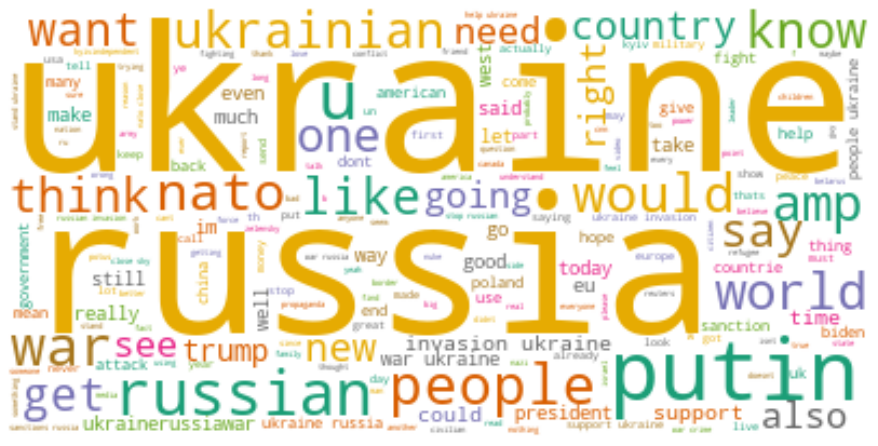

In [1013]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

tweet_word = " ".join(title for title in tweet_df.tweetText)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

In [960]:
tweet_df['tokenized_words']

0        [realpepeescobar, flush, those, fancy, degrees...
1        [hey, grantrandom, while, listening, to, sxmoc...
2        [stephen, king, stands, with, ukraine, stephen...
3        [kilogolfsierra, formwhisperer, edwardgluce, u...
4        [indianaimo, its, because, russia, is, a, nucl...
                               ...                        
15959    [lakotaman1, i, love, that, when, he, was, pre...
15960                 [may, there, be, peace, in, ukraine]
15961    [rtenews, i, ’, m, not, sure, if, i, even, bel...
15962    [naming, a, war, as, politics, it, ’, s, like,...
15963    [recent, polls, indicate, only, 13, of, the, r...
Name: tokenized_words, Length: 15964, dtype: object

In [961]:
tweet_df['tokenized_sentence']

0        [realpepeescobar flush those fancy degrees dow...
1        [hey grantrandom while listening to sxmoctane ...
2        [stephen king stands with ukraine\nstephenking...
3        [kilogolfsierra formwhisperer edwardgluce ukra...
4        [indianaimo its because russia is a nuclear su...
                               ...                        
15959    [lakotaman1 i love that when he was presented ...
15960                      [may there be peace in ukraine]
15961    [rtenews i’m not sure if i even believe that t...
15962    [naming a war as politics it’s like naming a r...
15963    [recent polls indicate only 13 of the republic...
Name: tokenized_sentence, Length: 15964, dtype: object

In [962]:
# remove stop words
tweet_df['tokenized_sentence']=tweet_df['tokenized_sentence'].apply(lambda x: [item for item in x if item not in stop_words])

In [963]:
tweet_df['tokenized_sentence'].dropna(inplace=True)
tweet_df['tokenized_sentence'].sample(5)

12851    [kyivindependent nato it now or never\n\nukrai...
8965     [sentdefender russia is going to freak the fk ...
3985     [ngrossman81 miscalculations can be a serious ...
14688    [savethenoname funder do you think the us woul...
8313     [lwalshmill gop they are no better than russia...
Name: tokenized_sentence, dtype: object

[('the', 9446),
 ('ukraine', 7258),
 ('to', 6854),
 ('russia', 4674),
 ('of', 4547),
 ('and', 4375),
 ('in', 4292),
 ('is', 3992),
 ('a', 3757),
 ('for', 2322),
 ('i', 2213),
 ('you', 2112),
 ('that', 2046),
 ('on', 1870),
 ('are', 1803),
 ('this', 1726),
 ('with', 1610),
 ('from', 1515),
 ('it', 1508),
 ('not', 1444),
 ('russian', 1363),
 ('putin', 1292),
 ('they', 1243),
 ('be', 1223),
 ('war', 1212),
 ('have', 1166),
 ('as', 1128),
 ('we', 1095),
 ('if', 1052),
 ('has', 1010),
 ('will', 1010),
 ('all', 943),
 ('but', 939),
 ('people', 897),
 ('us', 889),
 ('what', 886),
 ('about', 818),
 ('he', 787),
 ('was', 774),
 ('its', 766),
 ('by', 734),
 ('so', 725),
 ('nato', 722),
 ('no', 705),
 ('just', 661),
 ('how', 655),
 ('do', 654),
 ('now', 636),
 ('their', 618),
 ('can', 618),
 ('would', 593),
 ('invasion', 587),
 ('at', 576),
 ('world', 575),
 ('your', 518),
 ('out', 515),
 ('there', 505),
 ('like', 499),
 ('an', 499),
 ('who', 495),
 ('against', 479),
 ('why', 477),
 ('up', 470),


In [968]:
from nltk.probability import FreqDist
tweet_df['tweetText'].dropna(inplace=True)
fdist1 = FreqDist(sum(tweet_df['tweetText'].map(word_tokenize), []))

In [946]:
fdist1.most_common(50)

[('the', 9489),
 ('ukraine', 7405),
 ('to', 6857),
 ('russia', 4954),
 ('of', 4549),
 ('and', 4379),
 ('in', 4299),
 ('is', 3992),
 ('a', 3763),
 ('’', 2629),
 ('i', 2440),
 ('for', 2326),
 ('you', 2201),
 ('that', 2107),
 ('on', 1871),
 ('are', 1804),
 ('it', 1764),
 ('this', 1737),
 ('with', 1612),
 ('from', 1516),
 ('not', 1495),
 ('putin', 1395),
 ('russian', 1370),
 ('they', 1320),
 ('s', 1261),
 ('war', 1225),
 ('be', 1223),
 ('have', 1167),
 ('we', 1156),
 ('as', 1135),
 ('if', 1057),
 ('has', 1010),
 ('will', 1010),
 ('all', 962),
 ('but', 943),
 ('what', 933),
 ('people', 902),
 ('us', 892),
 ('he', 855),
 ('about', 818),
 ('was', 774),
 ('its', 766),
 ('can', 757),
 ('by', 734),
 ('so', 729),
 ('nato', 727),
 ('no', 708),
 ('t', 668),
 ('just', 661),
 ('how', 659)]

#### Save Cleaned Data

Save the cleaned data to cleaned_data.csv

In [783]:
tweet_df = tweet_df[['tweetID','tweetText','tweetdate','date','countrycode']]
# Overwrite or add
ans = input('Do you want overwrite the file? (y/n): ')
if (ans == 'y'):
    tweet_df.to_csv('./data/cleaned_data.csv', index=False)
else:  
    # check if the file exist, it will add the data 
    try:
        with open('./data/cleaned_data.csv') as f:
            print('Add The data to the existing file')
            tweet_df.to_csv('./data/cleaned_data.csv',mode='a', header=False, index=False)
    except IOError:
       print('Create new file')
       tweet_df.to_csv('./data/cleaned_data.csv', index=False)

In [ ]:
cleaned_tweet_df = pd.read_csv('./data/cleaned_data.csv')
cleaned_tweet_df.shape

In [ ]:
cleaned_tweet_df.head()

---------------------------------------------------------------------------------------------------

# Under Development  

In [ ]:
len(tweet_df[tweet_df.userLocation.isnull() & (tweet_df.countrycode.notnull())]) 

In [ ]:
tweet_df[(tweet_df.userLocation.isnull() & (tweet_df.countrycode.notnull()))]

In [ ]:
tweet_df.info()

In [ ]:
sns.set_theme(style="ticks")
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(
    tweet_df,
    x="TweetPlace",hue="TweetPlace", 
    multiple="stack",
    ax=ax,
)
plt.xticks(rotation=45)
plt.show()

In [ ]:
raw_df.tweetdate.value_counts()

In [ ]:
tweet_df.sample(100)

In [ ]:
tweet_df.userLocation.value_counts()

In [ ]:
tweet_df.retweeted.value_counts()

In [ ]:
tweet_df.tweetText.value_counts()

In [ ]:
tweet_df.date.value_counts()

In [ ]:
tweet_df.tweetID.value_counts()